# Setup

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent / "src"))

import dice
import dice.plots as dp

import warnings
import pandas as pd

from typing import Any
from dice.module import Module

warnings.simplefilter(action='ignore', category=UserWarning)

# Fill repository

In [2]:
def cls_init(mod: Module) -> None:
    mod.register_label("sample-label")

def cls_handler(mod: Module) -> None:
    fps = mod.repo().get_fingerprints(normalize=True)
    for fp in fps.itertuples(index=False):
        mod.label(str(fp.id), "sample-label")

def fp_handler(mod: Module) -> None:
    def fingerprint(rec: pd.Series) -> Any:
        data = {
            "vendor": rec.get("data_vendor"),
            "product": rec.get("data_product"),
            "version": rec.get("data_version")
        }
        mod.fingerprint(rec, data, protocol="sample")
        
    recs = mod.repo().get_records(source="records",normalize=True)
    recs.apply(fingerprint, axis=1)

sample_cls = dice.new_classifier(cls_handler, cls_init)
sample_fp = dice.new_fingerprinter(fp_handler)

srcs = [
    *dice.make_sources("sources/records.jsonl", name="records"),
    *dice.make_sources("sources/asn.jsonl", name="asn"),
]

engine = dice.new_engine(sample_cls, sample_fp)
repo = engine.run(srcs, "cosmos.db")
repo.summary()

{'fingerprinted': 4, 'labelled': 4}

# Load Data

In [2]:
from dice.repo import load_repository

try:
    repo # does exist
except NameError:
    repo = load_repository(db="cosmos.db")

In [3]:
from dice.query import query_fingerprinter

asn_data = (
    repo.get_records(source="asn")
    .drop_duplicates(subset="ip")
    .add_prefix("asn_")
    .rename(columns={"asn_ip": "host"})
)

vr = repo.with_view("records", query_fingerprinter(repo, protocol="sample"))
test_data = vr.collect()
test_data = test_data.merge(asn_data, on="host", how="left")
test_data

,id,host,record_id,module_name,port,protocol,labels,data_vendor,data_product,data_version,...,asn_contacts,asn_country,asn_city,asn_latitude,asn_longitude,asn_path,asn_source_id,asn_source_name,asn_study,asn_id
0,fp-mod_03bb6639-3792-4856-bdca-c1cf9db8d5db,1.1.1.2,9c779e51-17d6-4106-b97e-482f03898c03,fp-mod,1,sample,[sample-label],"""vendor-2""","""prod-1""","""v2.0""",...,"[""abc@de.fg""]",US,,1,-1,sources/asn.jsonl,4b53085e-21f6-49dc-abf0-f38009437f39,asn,-,45da8abc-f9de-4b4a-9ca8-008fb30c00cb
1,fp-mod_a39425a5-8f41-4d12-bc93-5cda48a984ce,1.1.1.1,d784dab8-825d-4d5a-9fbd-6b112fc5a535,fp-mod,1,sample,[sample-label],"""vendor-1""","""prod-2""","""v1.0""",...,"[""abc@de.fg""]",US,,1,-1,sources/asn.jsonl,4b53085e-21f6-49dc-abf0-f38009437f39,asn,-,5c4a3dad-bc0b-4f54-8e1e-31501a48e088
2,fp-mod_ca279bfb-23e3-42a2-b6fc-866d81ed443d,2.2.2.2,da342594-1608-4c30-a160-063e49082dd7,fp-mod,1,sample,[sample-label],"""vendor-1""","""prod-1""","""v1.0""",...,"[""abc@de.fg""]",DK,,1,-1,sources/asn.jsonl,4b53085e-21f6-49dc-abf0-f38009437f39,asn,-,9f3a4c46-9a0a-4ed3-9137-d6b2a7f7ac5f
3,fp-mod_ebc46585-6f35-4852-b3a6-b0a2b0c8e7f9,1.1.1.3,3dbab8ea-9039-4c0d-9583-0211e66a11f8,fp-mod,1,sample,[sample-label],"""vendor-2""","""prod-2""","""v1.0""",...,"[""abc@de.fg""]",CA,,1,-1,sources/asn.jsonl,4b53085e-21f6-49dc-abf0-f38009437f39,asn,-,98cd75ad-6589-49a7-bc04-070eb94fc79e


# Plots

In [4]:

lconfs = [
    dp.make_lab_conf("*", 'red'),
    dp.make_lab_conf("*:v1.0", 'rgba(100,100,100,0.5)'),
    dp.make_lab_conf("*:prod-2", 'rgba(0,0,0,0.7)'),
]

dp.sankey_figure(test_data, "vendor", "product", "version", lconfs=lconfs).show()

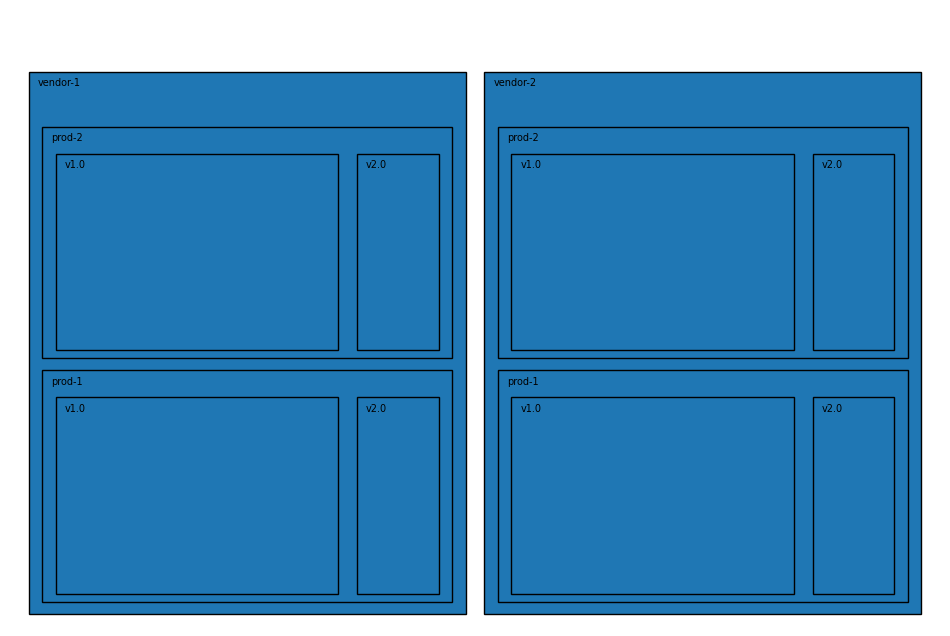

In [13]:
dp.mesh_figure(test_data, "vendor", "product", "version", prefix="data_").show()

/mnt/c/Users/rmyl/Documents/github/analysis/scan-tools/examples/.venv/lib/python3.13/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


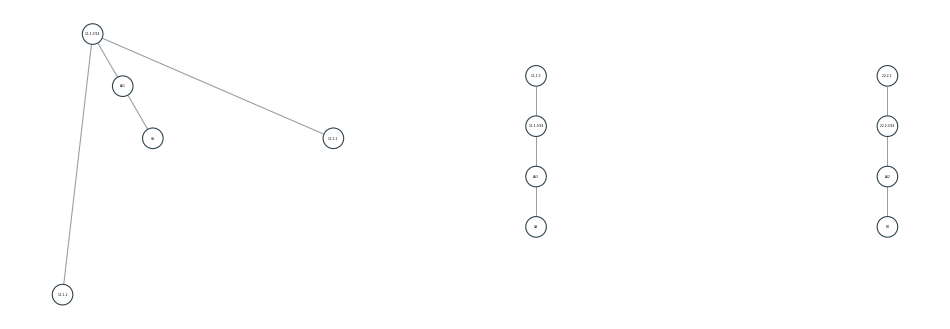

In [ ]:
dp.network_figure(test_data, "asn_country", "asn_asn_number", "asn_prefix", "host").show()

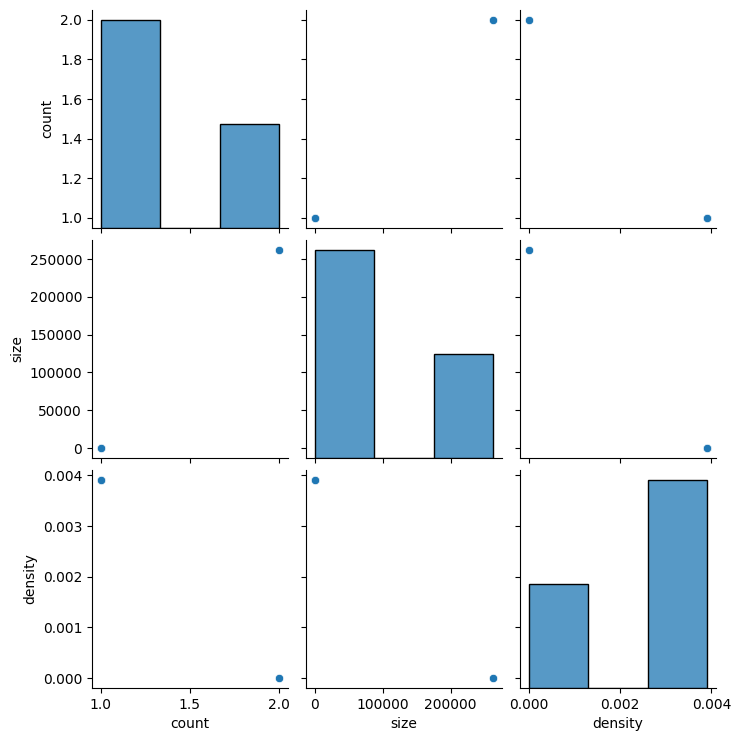

In [9]:
import dice.analysis as da
import matplotlib.pyplot as plt
import seaborn as sns

from dice.plots import network as pn

asn_counts = da.count_groups(test_data, "asn_prefix").reset_index()
asn_counts[["size", "density"]] = asn_counts.apply(
    lambda r: pn.prefix_density(r["asn_prefix"], r["count"]), 
    axis=1, result_type="expand"
)

sns.pairplot(asn_counts)
plt.show()